In [1]:
import numpy as np
import matplotlib.pyplot as plt

(1e-08, 0.01)

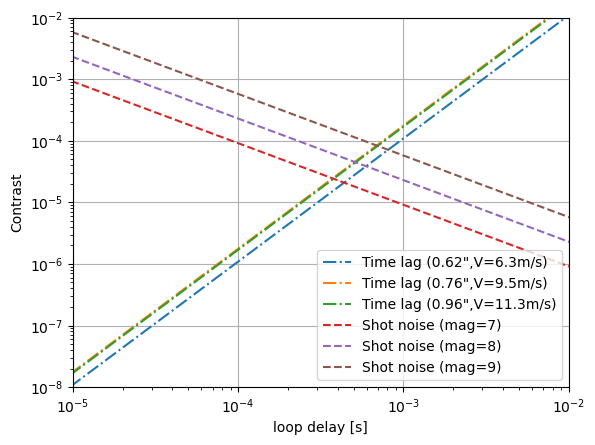

In [2]:
rad2arcsec = 180/np.pi*3600

seeing = 0.5
V = 10 #m/s
D = 8.2 # m
lambda0 = 550e-9
f = 3/D # lambda/D^2

B0 = 2.62e+10
thrp = 0.05
obs = 0.0
flux = lambda mag: B0 * thrp * 10**(-mag/2.5) * np.pi*(D*(1-obs))**2/4
Nphot = lambda mag,dt: flux(mag) * dt 

r0 = lambda seeing: 0.98*500e-9/(seeing/rad2arcsec) # m
C = lambda h,wavelength: (np.pi*h/wavelength)**2
h_lag = lambda V,seeing,f,dt: 0.22*2*np.pi*V*500e-9/(D*(f*r0(seeing))**(5/6))*dt


x = np.logspace(-6,-1,200)

Vvec = np.array([6.3,9.5,11.3])
seeings = np.array([0.62,0.76,0.96])
magV = np.array([7,8,9])

plt.figure()
for k in range(len(Vvec)):
    plt.plot(x,C(h_lag(Vvec[k],r0(seeings[k]),f,x),lambda0),'-.',label=f'Time lag ({seeings[k]:1.2f}",V={Vvec[k]:1.1f}m/s)')
for k in range(len(magV)):
    plt.plot(x,1/Nphot(magV[k],x),'--',label=f'Shot noise (mag={magV[k]:1.0f})')
plt.legend()
plt.xlabel('loop delay [s]')
plt.ylabel('Contrast')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim([1e-5,1e-2])
plt.ylim([1e-8,1e-2])


In [3]:
# beta = np.sqrt(2)
# rad2m = lambda0/(2*np.pi)

# plt.figure()
# for k in range(len(Vvec)):
#     plt.plot(x,h_lag(Vvec[k],r0(seeings[k]),f,x),'-.',label=f'Time lag ({seeings[k]:1.2f}",V={Vvec[k]:1.1f}m/s)')
# for k in range(len(magV)):
#     plt.plot(x,rad2m*beta/np.sqrt(Nphot(magV[k],x)),'--',label=f'Shot noise (mag={magV[k]:1.0f})')
# plt.legend()
# plt.xlabel('loop delay [s]')
# plt.ylabel(r'$WFE$')
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()
# plt.xlim([1e-5,1e-2])
# plt.ylim([1e-11,1e-7])

(0.1, 10)

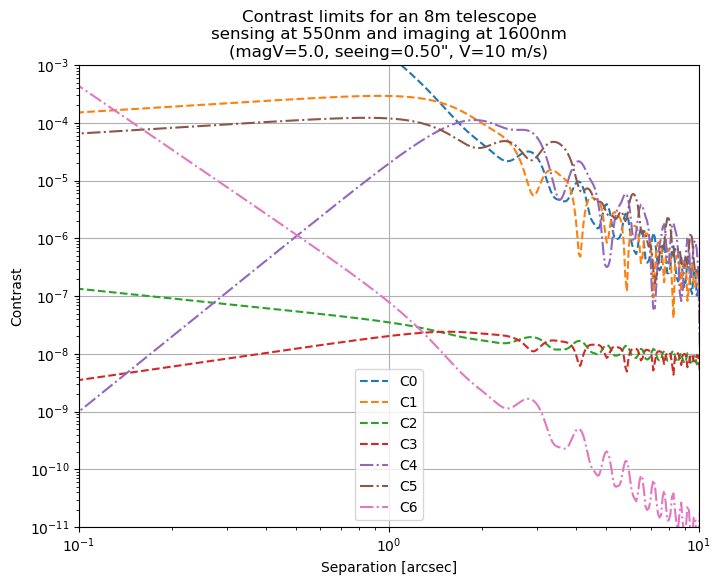

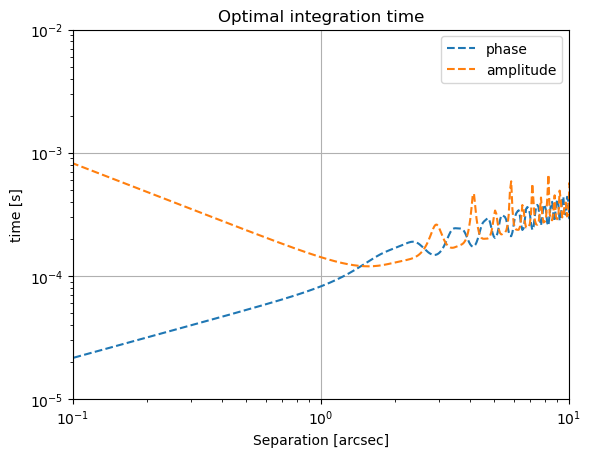

In [4]:
# Parameters
seeing = 0.5
V = 10
D = 8
magV = 5
Cn2_fracs = np.array([0.2283,0.0883,0.0666,0.1458,0.3350,0.1350])
altitudes = np.array([0.5,1,2,4,8,16])*1000

# Functions
X = lambda f,lambda_i: np.trapezoid(Cn2_fracs[:,None]*np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
Y = lambda f,lambda_i: np.trapezoid(Cn2_fracs[:,None]*np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
# Y = lambda f,lambda_i: 1-X(f,lambda_i) 

dX = lambda f,lambda_i,lambda_WFS: np.trapezoid(Cn2_fracs[:,None]*(np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)-np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_WFS))**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
dY = lambda f,lambda_i,lambda_WFS: np.trapezoid(Cn2_fracs[:,None]*(np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)-np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_WFS))**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)

# Air refractive index chromaticity
n = lambda l: 1.0+(8342.15+240603/(130-(l*1e+6)**(-2))+15997/(38.9-(l*1e+6)**(-2)))/10**8

C0 = lambda alpha, lambda_i: 0.484*np.pi**2*(500e-9)**2*(lambda_i)**(5/3)*X(alpha/lambda_i,lambda_i) / (alpha**(11/3)*D**2*r0(seeing)**(5/3))
C1 = lambda alpha, lambda_i: 0.484*np.pi**2*(500e-9)**2*(lambda_i)**(5/3)*Y(alpha/lambda_i,lambda_i) / (alpha**(11/3)*D**2*r0(seeing)**(5/3))
C2 = lambda alpha,lambda_i, lambda_WFS, beta_p, F: 0.7475*lambda_WFS**(4/3)*(500e-9)**(2/3)*beta_p**(4/3)*V**(2/3)*X(alpha/lambda_i,lambda_i)**(1/3) / (lambda_i**(13/9)*F**(2/3)*D**2*r0(seeing)**(5/9)*alpha**(5/9))
C3 = lambda alpha,lambda_i, lambda_WFS, beta_a, F: 0.7475*lambda_WFS**(4/3)*(500e-9)**(2/3)*beta_a**(4/3)*V**(2/3)*Y(alpha/lambda_i,lambda_i)**(1/3) / (lambda_i**(13/9)*F**(2/3)*D**2*r0(seeing)**(5/9)*alpha**(5/9))
C4 = lambda alpha, lambda_i, lambda_WFS: C0(alpha,lambda_i)*dX(alpha/lambda_i,lambda_i,lambda_WFS) / X(alpha/lambda_i,lambda_i)
C5 = lambda alpha, lambda_i, lambda_WFS: C1(alpha,lambda_i)*dY(alpha/lambda_i,lambda_i,lambda_WFS) / Y(alpha/lambda_i,lambda_i)
C6 = lambda alpha, lambda_i, lambda_WFS: C0(alpha,lambda_i)*((n(lambda_i)-n(lambda_WFS))/(1-n(lambda_i)))**2
t_p = lambda alpha, lambda_i, lambda_WFS, beta_p, F: (lambda_WFS/500e-9)**(2/3) * 0.204*beta_p*r0(seeing)**(5/9)*(alpha/lambda_i)**(5/9) / (F**(1/3) * V**(2/3) * X(alpha/lambda_i,lambda_i)**(1/3))
t_a = lambda alpha, lambda_i, lambda_WFS, beta_a, F: (lambda_WFS/500e-9)**(2/3) * 0.204*beta_a*r0(seeing)**(5/9)*(alpha/lambda_i)**(5/9) / (F**(1/3) * V**(2/3) * Y(alpha/lambda_i,lambda_i)**(1/3))

B0 = 9.74e+9 # ph/s/m^2
F = lambda mag: B0 * 10**(-mag/2.5)

alphas = np.logspace(-2,3,1000)/rad2arcsec
lambda_i = 1600e-9 # imaging wavelength
lambda_WFS = 550e-9 # WFS wavelength

beta_p = 1.0
beta_a = 1.0

plt.figure(figsize=(8,6))
plt.plot(alphas*rad2arcsec,C0(alphas,lambda_i),'--',label='C0')
plt.plot(alphas*rad2arcsec,C1(alphas,lambda_i),'--',label='C1')
plt.plot(alphas*rad2arcsec,C2(alphas,lambda_i, lambda_WFS, beta_p, F=F(magV)),'--',label='C2')
plt.plot(alphas*rad2arcsec,C3(alphas,lambda_i, lambda_WFS, beta_a, F=F(magV)),'--',label='C3')
plt.plot(alphas*rad2arcsec,C4(alphas,lambda_i, lambda_WFS),'-.',label='C4')
plt.plot(alphas*rad2arcsec,C5(alphas,lambda_i, lambda_WFS),'-.',label='C5')
plt.plot(alphas*rad2arcsec,C6(alphas,lambda_i, lambda_WFS),'-.',label='C6')
plt.axvspan(0.02,0.04, color='gray', alpha=0.3)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Contrast')
plt.xlabel('Separation [arcsec]')
plt.title(f'Contrast limits for an {D:1.0f}m telescope\nsensing at {lambda_WFS*1e+9:1.0f}nm and imaging at {lambda_i*1e+9:1.0f}nm\n(magV={magV:1.1f}, seeing={seeing:1.2f}", V={V:1.0f} m/s)')
plt.ylim([1e-11,1e-3])
plt.xlim([0.1,10])
plt.grid()

plt.figure()
plt.plot(alphas*rad2arcsec,t_p(alphas,lambda_i,lambda_WFS, beta_p,F=F(magV)),'--',label='phase')
plt.plot(alphas*rad2arcsec,t_a(alphas,lambda_i,lambda_WFS, beta_a,F=F(magV)),'--',label='amplitude')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time [s]')
plt.xlabel('Separation [arcsec]')
plt.title('Optimal integration time')
plt.ylim([1e-5,1e-2])
plt.xlim([0.1,10])

(0.01, 2)

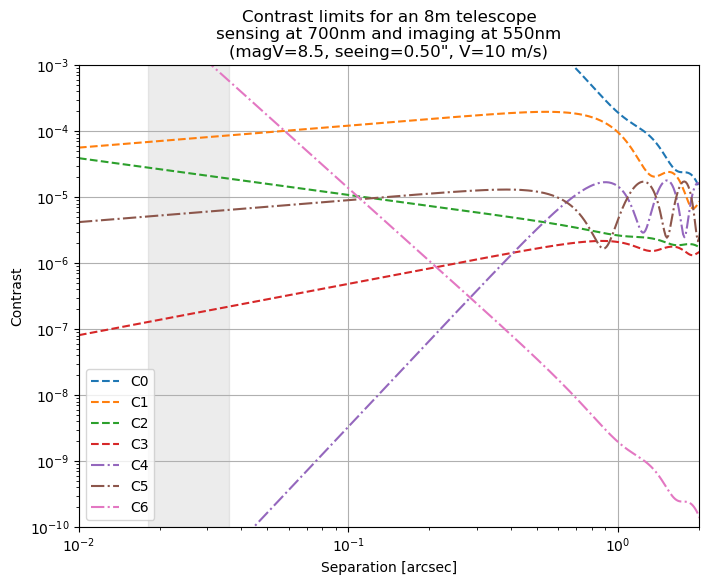

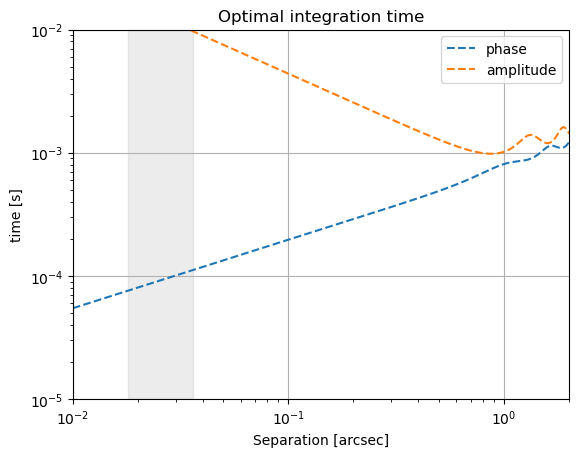

In [5]:
# Parameters
seeing = 0.5
V = 9.5
D = 8.2
magV = 8.5
# Cn2_fracs = np.array([0.0,0.2283,0.0883,0.0666,0.1458,0.3350,0.1350])
# altitudes = np.array([0.0,0.5,1,2,4,8,16])*1000
Cn2_fracs = np.array([0.0,0.646,0.078,0.119,0.035,0.025,0.08,0.017])
altitudes = np.array([0.0,0.022,1.8,3.3,5.8,7.4,13.1,15.8])*1000

# Functions
X = lambda f,lambda_i: np.trapezoid(Cn2_fracs[:,None]*np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
Y = lambda f,lambda_i: np.trapezoid(Cn2_fracs[:,None]*np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
# Y = lambda f,lambda_i: 1-X(f,lambda_i) 

dX = lambda f,lambda_i,lambda_WFS: np.trapezoid(Cn2_fracs[:,None]*(np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)-np.cos(np.pi*altitudes[:,None]*f[None,:]**2*lambda_WFS))**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)
dY = lambda f,lambda_i,lambda_WFS: np.trapezoid(Cn2_fracs[:,None]*(np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_i)-np.sin(np.pi*altitudes[:,None]*f[None,:]**2*lambda_WFS))**2,altitudes,axis=0)/np.trapezoid(Cn2_fracs,altitudes)

# Air refractive index chromaticity
n = lambda l: 1.0+(8342.15+240603/(130-(l*1e+6)**(-2))+15997/(38.9-(l*1e+6)**(-2)))/10**8

C0 = lambda alpha, lambda_i: 0.484*np.pi**2*(500e-9)**2*(lambda_i)**(5/3)*X(alpha/lambda_i,lambda_i) / (alpha**(11/3)*D**2*r0(seeing)**(5/3))
C1 = lambda alpha, lambda_i: 0.484*np.pi**2*(500e-9)**2*(lambda_i)**(5/3)*Y(alpha/lambda_i,lambda_i) / (alpha**(11/3)*D**2*r0(seeing)**(5/3))
C2 = lambda alpha,lambda_i, lambda_WFS, beta_p, F: 0.7475*lambda_WFS**(4/3)*(500e-9)**(2/3)*beta_p**(4/3)*V**(2/3)*X(alpha/lambda_i,lambda_i)**(1/3) / (lambda_i**(13/9)*F**(2/3)*D**2*r0(seeing)**(5/9)*alpha**(5/9))
C3 = lambda alpha,lambda_i, lambda_WFS, beta_a, F: 0.7475*lambda_WFS**(4/3)*(500e-9)**(2/3)*beta_a**(4/3)*V**(2/3)*Y(alpha/lambda_i,lambda_i)**(1/3) / (lambda_i**(13/9)*F**(2/3)*D**2*r0(seeing)**(5/9)*alpha**(5/9))
C4 = lambda alpha, lambda_i, lambda_WFS: C0(alpha,lambda_i)*dX(alpha/lambda_i,lambda_i,lambda_WFS) / X(alpha/lambda_i,lambda_i)
C5 = lambda alpha, lambda_i, lambda_WFS: C1(alpha,lambda_i)*dY(alpha/lambda_i,lambda_i,lambda_WFS) / Y(alpha/lambda_i,lambda_i)
C6 = lambda alpha, lambda_i, lambda_WFS: C0(alpha,lambda_i)*((n(lambda_i)-n(lambda_WFS))/(1-n(lambda_i)))**2
t_p = lambda alpha, lambda_i, lambda_WFS, beta_p, F: (lambda_WFS/500e-9)**(2/3) * 0.204*beta_p*r0(seeing)**(5/9)*(alpha/lambda_i)**(5/9) / (F**(1/3) * V**(2/3) * X(alpha/lambda_i,lambda_i)**(1/3))
t_a = lambda alpha, lambda_i, lambda_WFS, beta_a, F: (lambda_WFS/500e-9)**(2/3) * 0.204*beta_a*r0(seeing)**(5/9)*(alpha/lambda_i)**(5/9) / (F**(1/3) * V**(2/3) * Y(alpha/lambda_i,lambda_i)**(1/3))

B0 = 9.74e+9 # ph/s/m^2
F = lambda mag: B0 * 10**(-mag/2.5)

alphas = np.logspace(-2,3,1000)/rad2arcsec
lambda_i = 550e-9 # imaging wavelength
lambda_WFS = 700e-9 # WFS wavelength

beta_p = np.sqrt(2)#1.0
beta_a = np.sqrt(2)#1.0

plt.figure(figsize=(8,6))
plt.plot(alphas*rad2arcsec,C0(alphas,lambda_i),'--',label='C0')
plt.plot(alphas*rad2arcsec,C1(alphas,lambda_i),'--',label='C1')
plt.plot(alphas*rad2arcsec,C2(alphas,lambda_i, lambda_WFS, beta_p, F=F(magV)),'--',label='C2')
plt.plot(alphas*rad2arcsec,C3(alphas,lambda_i, lambda_WFS, beta_a, F=F(magV)),'--',label='C3')
plt.plot(alphas*rad2arcsec,C4(alphas,lambda_i, lambda_WFS),'-.',label='C4')
plt.plot(alphas*rad2arcsec,C5(alphas,lambda_i, lambda_WFS),'-.',label='C5')
plt.plot(alphas*rad2arcsec,C6(alphas,lambda_i, lambda_WFS),'-.',label='C6')
plt.axvspan(0.018,0.036, color='gray', alpha=0.15)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Contrast')
plt.xlabel('Separation [arcsec]')
plt.title(f'Contrast limits for an {D:1.0f}m telescope\nsensing at {lambda_WFS*1e+9:1.0f}nm and imaging at {lambda_i*1e+9:1.0f}nm\n(magV={magV:1.1f}, seeing={seeing:1.2f}", V={V:1.0f} m/s)')
plt.ylim([1e-10,1e-3])
plt.xlim([0.01,2])
plt.grid()


plt.figure()
plt.plot(alphas*rad2arcsec,t_p(alphas,lambda_i,lambda_WFS, beta_p,F=F(magV)),'--',label='phase')
plt.plot(alphas*rad2arcsec,t_a(alphas,lambda_i,lambda_WFS, beta_a,F=F(magV)),'--',label='amplitude')
plt.axvspan(0.018,0.036, color='gray', alpha=0.15)
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('time [s]')
plt.xlabel('Separation [arcsec]')
plt.title('Optimal integration time')
plt.ylim([1e-5,1e-2])
plt.xlim([0.01,2])